In [1]:
from model import Wav2Vec2Model,Wav2Vec2Config,Wav2Vec2ForPreTraining,Wav2Vec2ForSequenceClassification
import random
from dataset import AudioDataset,AudioDatasetSplits
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from safetensors import safe_open
import os
from sklearn.metrics import f1_score,accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'


config = Wav2Vec2Config()#.from_pretrained('weights/config.json')

# Initialize the model architecture using the configuration
pre_trained_model = Wav2Vec2ForPreTraining(config)

# #Load the weights from the safetensors file
# state_dict = {}
# with safe_open('weights/model.safetensors', framework="pt", device=device) as f:
#     for key in f.keys():
#         state_dict[key] = f.get_tensor(key)

# Load the state dict into the model
#pre_trained_model.load_state_dict(state_dict)

datasets = AudioDatasetSplits()

In [2]:
datasets.train.label_2_id()

{'Crochet': 0,
 'Gould': 1,
 'Horowitz': 2,
 'Ishizaka': 3,
 'Moravec': 4,
 'Nikolayeva': 5,
 'Pogorelich': 6,
 'Richter': 7,
 'Rubinstein': 8,
 'Schiff': 9,
 'Tharaud': 10,
 'Tureck': 11}

In [5]:
model = Wav2Vec2ForSequenceClassification(pre_trained_model,datasets.num_classes)

model = model.to(device)

#state_dict = torch.load('finetune_weights/model_epoch_10.pt')
#model.load_state_dict(state_dict)

for i in range(10):
    ip,_,label = datasets.train[i].values()
    out = model(ip[0].unsqueeze(0).to(device)).argmax(dim=1)

    print(out.item(),label)

2 8
0 3
10 10
11 3
7 10
6 4
11 0
7 3
2 8
2 1


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=2)


train_dataloader = DataLoader(datasets.train, batch_size=8, shuffle=True)
val_dataloader = DataLoader(datasets.val, batch_size=8, shuffle=True)



In [20]:
epochs = 10

for epoch in range(epochs):
    torch.cuda.empty_cache()
    model.train()
    batch_iterator = tqdm(train_dataloader,desc=f'Processing Epoch: {epoch:02d}')
    running_loss = 0.0
    for batch_idx,batch in enumerate(batch_iterator):

        ip = batch['input_values'][0].to(device)

        labels = batch['label'].to(device)

        out = model(ip)



    

        loss = loss_fn(out,labels)


        optimizer.zero_grad()

        

        loss.backward()


        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()

        batch_iterator.set_postfix(loss=running_loss / (1 if batch_idx == 0 else batch_idx))
   # break
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        val_iterator = tqdm(val_dataloader,desc=f"Validating epoch: {epoch}")

        for idx,batch in enumerate(val_iterator):
            ip = batch['input_values'][0].to(device)

            labels = batch['label'].to(device)

            out = model(ip)

            loss = loss_fn(out,labels)

            val_loss += loss.item()

            probs = torch.softmax(out,dim=1)
            preds = torch.argmax(probs,dim=1)

            

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())



    val_acc = accuracy_score(all_labels,all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    torch.save(model.state_dict(), os.path.join('finetune_weights', f'model_epoch_{epoch+1}.pt'))

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss / len(val_dataloader)}, Validation F1 Score: {val_f1:.2f},Validation Acc: {val_acc:.2f}')




Processing Epoch: 00:   0%|          | 7/1550 [00:02<07:29,  3.43it/s, loss=3.82]


KeyboardInterrupt: 

In [7]:
test_dataloader = DataLoader(datasets.test, batch_size=8, shuffle=True)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
test_loss = 0.0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    test_iterator = tqdm(test_dataloader, desc="Testing")

    for idx, batch in enumerate(test_iterator):
        ip = batch['input_values'][0].to(device)
        labels = batch['label'].to(device)

        out = model(ip)

        loss = loss_fn(out, labels)
        test_loss += loss.item()

        probs = torch.softmax(out, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())


Testing:  17%|█▋        | 33/194 [00:02<00:13, 11.59it/s]


KeyboardInterrupt: 

In [9]:
out

tensor([[-0.0080, -0.2084, -0.0423, -0.4985, -0.2038, -0.1070,  0.1071,  0.2716,
         -0.3217, -0.2690, -0.1485,  0.2138],
        [-0.0560, -0.1764, -0.0788, -0.5475, -0.3110, -0.1782,  0.1438,  0.3888,
         -0.2949, -0.1550, -0.0976,  0.1872],
        [-0.0312,  0.0587, -0.1124, -0.2000, -0.0778, -0.3107, -0.1835, -0.0067,
         -0.1363, -0.0698, -0.0905,  0.0088],
        [-0.0319, -0.1769, -0.1364, -0.4769, -0.3095, -0.1512,  0.1077,  0.3843,
         -0.3018, -0.1058, -0.0711,  0.1660],
        [ 0.0204, -0.1716, -0.1341, -0.4283, -0.3477, -0.2168,  0.0743,  0.3569,
         -0.2160, -0.1695, -0.0198,  0.2092],
        [-0.1195, -0.1463, -0.1159, -0.4548, -0.3817, -0.1064,  0.0966,  0.3717,
         -0.3591, -0.1848, -0.1085,  0.1496],
        [-0.0536, -0.1906, -0.1652, -0.5038, -0.2367, -0.1314,  0.0612,  0.4450,
         -0.3127,  0.0078, -0.0221,  0.2459],
        [-0.0750, -0.1968, -0.0298, -0.5085, -0.3027,  0.0065,  0.2021,  0.2740,
         -0.2980, -0.1177, -0.

In [10]:
probs

tensor([[0.0894, 0.0732, 0.0864, 0.0547, 0.0735, 0.0810, 0.1003, 0.1182, 0.0653,
         0.0689, 0.0777, 0.1116],
        [0.0844, 0.0748, 0.0825, 0.0516, 0.0654, 0.0747, 0.1031, 0.1317, 0.0665,
         0.0765, 0.0810, 0.1077],
        [0.0885, 0.0968, 0.0816, 0.0747, 0.0845, 0.0669, 0.0760, 0.0907, 0.0797,
         0.0851, 0.0834, 0.0921],
        [0.0863, 0.0746, 0.0777, 0.0553, 0.0654, 0.0766, 0.0992, 0.1308, 0.0659,
         0.0801, 0.0830, 0.1052],
        [0.0906, 0.0747, 0.0776, 0.0578, 0.0627, 0.0714, 0.0956, 0.1268, 0.0715,
         0.0749, 0.0870, 0.1094],
        [0.0807, 0.0785, 0.0810, 0.0577, 0.0621, 0.0818, 0.1001, 0.1319, 0.0635,
         0.0756, 0.0816, 0.1056],
        [0.0823, 0.0718, 0.0736, 0.0525, 0.0686, 0.0762, 0.0923, 0.1356, 0.0635,
         0.0875, 0.0850, 0.1111],
        [0.0825, 0.0731, 0.0864, 0.0535, 0.0657, 0.0896, 0.1089, 0.1170, 0.0660,
         0.0791, 0.0783, 0.0999]], device='cuda:0')

Test Loss: 0.42679942268686194, Test F1 Score: 0.01, Test Acc: 0.09


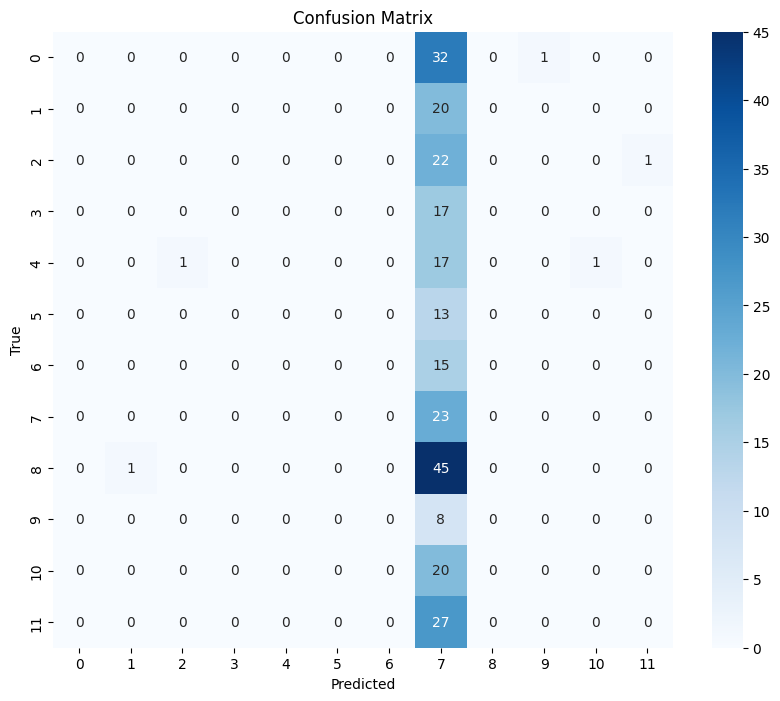

Classification Report:
               precision    recall  f1-score   support

     Crochet       0.00      0.00      0.00        33
       Gould       0.00      0.00      0.00        20
    Horowitz       0.00      0.00      0.00        23
    Ishizaka       0.00      0.00      0.00        17
     Moravec       0.00      0.00      0.00        19
  Nikolayeva       0.00      0.00      0.00        13
  Pogorelich       0.00      0.00      0.00        15
     Richter       0.09      1.00      0.16        23
  Rubinstein       0.00      0.00      0.00        46
      Schiff       0.00      0.00      0.00         8
     Tharaud       0.00      0.00      0.00        20
      Tureck       0.00      0.00      0.00        27

    accuracy                           0.09       264
   macro avg       0.01      0.08      0.01       264
weighted avg       0.01      0.09      0.01       264



/home/luke/projects/jupyterlab/Notebooks/song2vec/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luke/projects/jupyterlab/Notebooks/song2vec/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luke/projects/jupyterlab/Notebooks/song2vec/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [11]:
test_acc = accuracy_score(all_test_labels, all_test_preds)
test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'Test Loss: {test_loss / len(test_dataloader)}, Test F1 Score: {test_f1:.2f}, Test Acc: {test_acc:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_test_labels, all_test_preds, target_names=list(datasets.test.id_2_label().values()))
print("Classification Report:\n", class_report)
